In [1]:
import netCDF4
import pathlib as path
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from fnmatch import fnmatch
from typing import Iterable
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
vars_to_read = ['Time','GGALT','LATC','LONC', # 4-D Position
                'UIC','VIC','WIC',            # winds
                'ATX','PSXC','EWX','RHUM',           # other state params
                ] 

In [3]:
def find_flight_fnames(dir_path: str) -> list[str]:
    """
    find_flight_fnames just searches a directory for all *.nc files and returns a list of them.

    :param dir_path: a path to the directory containing flight netcdf files

    :return: Returns a list of flight netcdf files.
    """
    flight_paths=[]
    flight_fnames = sorted([fname for fname in os.listdir(dir_path) if fnmatch(fname, "*.nc")])
    for i in range(len(flight_fnames)):
        flight_paths.append(dir_path + '/' + flight_fnames[i])
    
    return flight_paths
    
def find_nc_fnames(dir_path: str) -> list[str]:
    """
    find_flight_fnames just searches a directory for all *.nc files and returns a list of them.
    
    :param dir_path: a path to the directory containing flight netcdf files
    
    :return: Returns a list of flight netcdf files.
    """
    nc_paths=[]
    nc_fnames = sorted([fname for fname in os.listdir(dir_path) if fnmatch(fname, "*.nc")])
    for i in range(len(nc_fnames)):
        nc_paths.append(dir_path + '/' + nc_fnames[i])
        
        nudg_path = [file for file in nc_paths if ".hs." in file]
        free_path = [file for file in nc_paths if ".h0." in file]
        # save dictionary with the paths for 
        model_paths = {'Free': free_path,'Nudg': nudg_path}
        
    return model_paths

def open_nc(paths: str) -> netCDF4._netCDF4.Dataset:
    """
    open_flight_nc simply checks to see if the file at the provided path string exists and opens it.

    :param file_path: A path string to a flight data file, e.g. "./test/test_flight.nc"

    :return: Returns xr.open_dataset object.
    """

    nc_path = path.Path(paths)
    if not nc_path.is_file():
        raise FileNotFoundError('testing excptions')

    return xr.open_dataset(paths)

def read_flight_nc_1hz(nc: xr.open_dataset, read_vars: list[str] = vars_to_read) -> pd.DataFrame:
    """
    read_flight_nc reads a set of variables into memory.

    NOTE: a low-rate, 1 Hz, flight data file is assumed

    :param nc: netCDF4._netCDF4.Dataset object opened by open_flight_nc.
    :param read_vars: An optional list of strings of variable names to be read into memory. A default
                      list, vars_to_read, is specified above. Passing in a similar list will read in those variables
                      instead.

    :return: Returns a pandas data frame.
    """

    data = [] # an empty list to accumulate Dataframes of each variable to be read in
    for var in read_vars:
        try:
            if var == "Time":
                # time is provided every second, so need to calculate 25 Hz times efficiently
                # tunits = getattr(nc[var],'units')
                # df = xr.open_dataset(nc)
                time = np.array(nc.Time)
                data.append(pd.DataFrame({var: time}))
                # dt_list = sfm_to_datetime(time, tunits)
                # data.append(pd.DataFrame({'datetime': time}))
            else:
                output = nc[var][:]
                data.append(pd.DataFrame({var: output}))
        except Exception as e:
            print(f"Issue reading {var}: {e}")
            pass
    

    # concatenate the list of dataframes into a single dataframe and return it
    return pd.concat(data, axis=1, ignore_index=False)



### Filter CESM data for a single flight

In [111]:
def filt_model_dims(cesm_dat,df):
    """
    Returns the lat, lon, and time from the nudged file that occur during specific research flight
    
    This function maps aircraft data onto a predefined grid based on CESM data
    
    NOTE: A low-rate, 1 Hz, flight data file is assumed.
    
    :param gv_dat: A dataset object containing aircraft data (e.g., LATC, LONC, U, V, T).
    :param cesm_dat: A dataset object containing CESM data (e.g., lat, lon, lev).
    
    :return: A dictionary containing latitude (lats), longitude (lons), and time 
             for grid cells where data is present.
    """
    da = xr.DataArray(cesm_dat.time, dims="time")
    cesm_times = pd.to_datetime([pd.Timestamp(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
                        for dt in da.values])
    
    aircraft_times = df.Time
    
    matching_indices = cesm_times.isin(aircraft_times)
    # Assuming cesm_dat.lat and matching_indices are already defined
    # Create a boolean mask for lat values you want to exclude
    lat = np.array(cesm_dat.lat[matching_indices])  # This gives the full lat array
    lon = np.array(cesm_dat.lon[matching_indices])  # This gives the full lat array
    time = np.array(cesm_times[matching_indices])  # This gives the full lat array
    
    # Define a threshold for what is considered a "high" difference
    lat_threshold = 2  # You can adjust this value
    lon_threshold = 5
    
    # Find the indices where the difference exceeds the threshold
    outlier_indices_lat = np.where(np.abs(np.diff(lat)) > lat_threshold)[0]
    outlier_indices_lon = np.where(np.abs(np.diff(lon)) > lon_threshold)[0]
    
    outliers = np.array([])
    
    for i in range(0,len(outlier_indices_lat)-1):
        if lat[outlier_indices_lat[i+1]] < lat[outlier_indices_lat[i]]:
            outliers = np.append(outliers, int(outlier_indices_lat[i+1]))
        elif lat[outlier_indices_lat[i]] < lat[outlier_indices_lat[i+1]]:
            outliers = np.append(outliers, int(outlier_indices_lat[i]))
            
    for i in range(0,len(outlier_indices_lon)-1):
        if lon[outlier_indices_lon[i+1]] < lon[outlier_indices_lon[i]]:
            outliers = np.append(outliers, int(outlier_indices_lon[i+1]))
        elif lon[outlier_indices_lon[i+1]] > lon[outlier_indices_lon[i]]:
            outliers = np.append(outliers, int(outlier_indices_lon[i]))
    # print(outliers)      
    # Create the exclude_mask, same length as lat, initially filled with False
    exclude_mask = np.zeros_like(lat, dtype=bool)  # Shape matches lat
    
    # # Set the outlier indices to True in the exclude_mask
    exclude_mask[outliers.astype(int)] = True  # Mark outliers as True, which will exclude them
    
    final_mask = ~exclude_mask
    
    # check if there are any remaining outliers, usually at the beginning of the array where there's two consecutive outliers
    lat_check = lat[final_mask]
    outlier_indices_lat = np.where(np.abs(np.diff(lat_check)) > lat_threshold)[0]
    if len(outlier_indices_lat) > 0:
        outliers = np.concatenate((outlier_indices_lat, outliers))
        # # Set the outlier indices to True in the exclude_mask
        exclude_mask[outliers.astype(int)] = True  # Mark outliers as True, which will exclude them
    
        final_mask = ~exclude_mask
    
    filter_cesm_dims = {'lat': lat[final_mask],
                        'lon': lon[final_mask],
                        'time': time[final_mask]
                       }
    
    return filter_cesm_dims

{'lat': array([-42.87958115, -42.87958115, -42.87958115, -42.87958115,
        -42.87958115, -42.87958115, -42.87958115, -42.87958115,
        -42.87958115, -42.87958115, -42.87958115, -42.87958115,
        -42.87958115, -42.87958115, -42.87958115, -42.87958115,
        -42.87958115, -42.87958115, -42.87958115, -42.87958115,
        -42.87958115, -42.87958115, -42.87958115, -42.87958115,
        -42.87958115, -42.87958115, -42.87958115, -42.87958115,
        -42.87958115, -42.87958115, -42.87958115, -42.87958115,
        -42.87958115, -43.82198953, -43.82198953, -43.82198953,
        -43.82198953, -43.82198953, -43.82198953, -43.82198953,
        -43.82198953, -44.76439791, -44.76439791, -44.76439791,
        -44.76439791, -44.76439791, -44.76439791, -44.76439791,
        -44.76439791, -44.76439791, -45.70680628, -45.70680628,
        -45.70680628, -45.70680628, -45.70680628, -45.70680628,
        -45.70680628, -45.70680628, -45.70680628, -46.64921466,
        -46.64921466, -46.6492146

In [134]:
def grid_flight_dat(filter_cesm_dims: dict, df: pd.DataFrame, cesm_dat: xr.Dataset) -> dict:
    """
    Maps aircraft data into CESM model grid boxes based on pressure levels.
    
    :param filter_cesm_dims: Dictionary containing filtered CESM lat, lon, and time.
    :param df: DataFrame containing aircraft data with 'Time' and 'PSXC' (pressure altitude).
    :param cesm_dat: Xarray dataset containing CESM pressure levels ('lev').
    
    :return: Dictionary containing interpolated latitude, longitude, altitude, time, and other aircraft data statistics.
    """
    
    lev = np.array(cesm_dat.lev)  # Model pressure levels
    times = filter_cesm_dims['time']
    lats, lons = filter_cesm_dims['lat'], filter_cesm_dims['lon']
    
    # Preallocate lists for better performance
    mid_lat, mid_lon, mid_alt, mid_time, mean_t, mean_w, mean_p, w_pdf = [], [], [], [], [], [], [], []
    change_indices = [i for i in range(1, len(times)) if times[i] != times[i-1]]
    change_indices.insert(0, 0)  # Insert 0 at the beginning
    # change_indices= change_indices[:-1]
    
    for t in range(0,len(times)-1):
        # print(t)
        # if t != change_indices[-1]:
        #     time_start, time_end = times[t], times[t+30]
        # else:
        #     time_start, time_end = times[t], times[-1]
        # print(time_start, time_end)
        time_start, time_end = times[t], times[t+1]
        # Select aircraft data between time intervals
        air_time_indices = (df['Time'] > time_start) & (df['Time'] <= time_end)
        sliced_df_time = df[air_time_indices]
    
        if not sliced_df_time.empty:  # Proceed only if there is data
            palt = np.array(sliced_df_time['PSXC'])
    
            for i in range(len(lev) - 1):
                # Find indices where pressure altitude is within level bounds
                lev_indices = (palt <= lev[i + 1]) & (palt > lev[i])
    
                if np.any(lev_indices):  # If data exists in this pressure level
                    sliced_df_alt = sliced_df_time[lev_indices]
    
                    # Midpoint calculations
                    mid_lat.append((lats[t] + lats[t+1]) / 2)# if t == 0 else (lats[t+1] + lats[t+2]) / 2)
                    mid_lon.append((lons[t] + lons[t+1]) / 2)
                    mid_alt.append((lev[i+1] + lev[i]) / 2)
    
                    ######### Calculate basic meteorological statistics ###########
                    mean_t.append(np.mean(sliced_df_alt['ATX']))
                    mean_w.append(np.mean(sliced_df_alt['WIC']))
                    mean_p.append(np.mean(sliced_df_alt['PSXC']))
                    ######### Calculate PDFs of w
                    # Estimate mean and standard deviation
                    mu, sigma = np.mean(np.array(sliced_df_alt['WIC'])), np.std(np.array(sliced_df_alt['WIC']))
                    
                    # Compute PDF using normal distribution
                    wind_speed_range = np.linspace(min(np.array(sliced_df_alt['WIC'])), max(np.array(sliced_df_alt['WIC'])), 50)
                    pdf_values = norm.pdf(wind_speed_range, mu, sigma)
                    
                    # Append PDF
                    w_pdf.append(pdf_values)
    
                    # Compute middle time as the midpoint of the first and last measurement
                    time_values = sliced_df_alt['Time'].values
                    mid_time.append(time_values[0] + (time_values[-1] - time_values[0]) / 2)
    
    # Convert lists to NumPy arrays for better performance
    grid_air_dat = {
        'Time': np.array(mid_time),
        'Alt': np.array(mid_alt),
        'Lat': np.array(mid_lat),
        'Lon': np.array(mid_lon),
        'Temp': np.array(mean_t),
        'Pres': np.array(mean_p),
        'w': np.array(mean_w),
        'w PDF': np.array(w_pdf),
    }
    
    return grid_air_dat
    # grid_air_dat

In [109]:

wind_speed_range = np.linspace(min(np.array(sliced_df_alt['WIC'])), max(np.array(sliced_df_alt['WIC'])), 50)
gaussian_pdf = grid_air_dat['w PDF'][0]

# plt.plot(wind_speed_range, gaussian_pdf, label="Gaussian PDF", color="red", linestyle="dashed", linewidth=2)

## Read data and run gridding functions

In [138]:
cesm_dir = '/Users/patnaude/Documents/Data/cesmdata'

cesm_files = find_nc_fnames(cesm_dir)
cesm_dat = open_nc(cesm_files['Nudg'][0])

dir = '/Users/patnaude/Documents/Data/SOCRATES'
flight_paths = find_flight_fnames(dir)
# flight_paths
nc = open_nc(flight_paths[10])
df = read_flight_nc_1hz(nc,vars_to_read)


filter_cesm_dims =filt_model_dims(cesm_dat,df)
grid_air_dat = grid_flight_dat(filter_cesm_dims,df,cesm_dat)

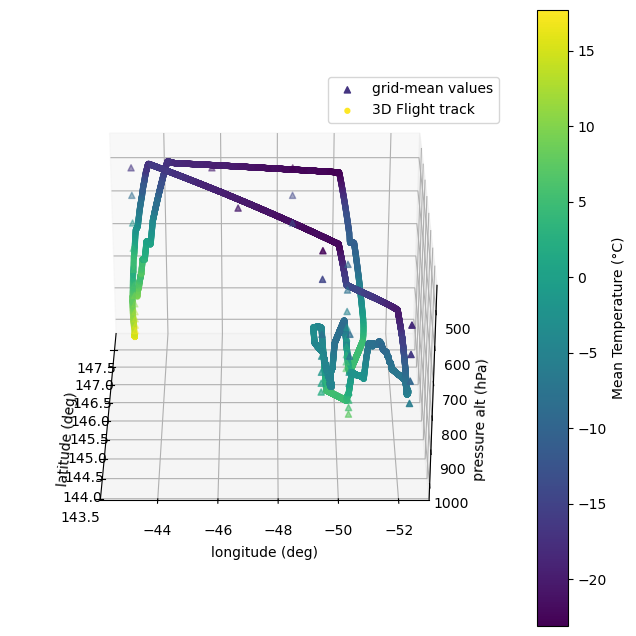

In [139]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation  


# grid_air_dat = grid_flight_dat(filter_cesm_dims,df,cesm_dat)

# Create a figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(grid_air_dat['Lon'], grid_air_dat['Lat'], grid_air_dat['Alt'], c=grid_air_dat['Temp'], cmap='viridis', marker='^',label='grid-mean values')
# Invert the Z-axis
ax.scatter(nc.LONC, nc.LATC, nc.PSXC, c=nc.ATX, label='3D Flight track',s=12)
ax.invert_zaxis()

ax.set_xlabel('latitude (deg)')
ax.set_ylabel('longitude (deg)')
ax.set_zlabel('pressure alt (hPa)') 

ax.legend()
# # Color bar to show the mapping of color to the fourth dimension
plt.colorbar(sc, label='Mean Temperature (°C)')

# Animation function to rotate the view
def rotate(angle):
    ax.view_init(elev=30, azim=angle)

# Create animation
ani = FuncAnimation(fig, rotate, frames=np.arange(-180, 360, 20), interval=150)

# Show the animation in Jupyter Notebook
from IPython.display import HTML
HTML(ani.to_jshtml())
# Labels


# # Show the plot
# plt.show()


### Write gridded aircraft data as netCDF

In [455]:
# def write_nc(grid_air_dat):
# Create an xarray Dataset

time = grid_air_dat['Time']
alt = grid_air_dat['Alt']
lat = grid_air_dat['Lat']
lon = grid_air_dat['Lon']

t = grid_air_dat['Temp']
w = grid_air_dat['w']
w_pdf = grid_air_dat['w PDF']

ds = xr.Dataset(
    {
        "temperature": t, 
        "wind_speed":(w),  
        
    },
    coords={
        "time": time,
        "lat": lat,
        "lon": lon,
        "alt": alt,
    },
)

ds


<xarray.Dataset> Size: 2kB
Dimensions:      (temperature: 54, wind_speed: 54, time: 54, lat: 54, lon: 54,
                  alt: 54)
Coordinates:
  * temperature  (temperature) float32 216B -10.66 -1.7 3.676 ... 9.279 11.83
  * wind_speed   (wind_speed) float32 216B 0.04681 2.307 1.539 ... 0.4545 0.1063
  * time         (time) datetime64[ns] 432B 2018-01-28T23:16:30 ... 2018-01-2...
  * lat          (lat) float64 432B -45.24 -45.24 -45.24 ... -42.88 -42.88
  * lon          (lon) float64 432B 147.5 147.5 147.5 ... 148.7 148.7 148.7
  * alt          (alt) float64 432B 485.3 567.2 650.6 ... 650.6 727.4 792.1
Data variables:
    *empty*